# 50.040 Natural Language Processing (Summer 2021) Homework 1

**Due 3rd June 2022, 5pm**


### STUDENT ID: 1004335

### Name: Dody Senputra

### Students with whom you have discussed (if any):

In [140]:
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
import time
# import numba

## Introduction
Word embeddings are dense vectors that represent words, and capable of capturing semantic and syntactic similarity, relation with other words, etc.
We have introduced two approaches in the class to learn word embeddings: **Count-based** and **Prediction-based**. 
Here we will explore both approaches. Note that we use "word embeddings" and "word vectors" interchangeably.

-------

Before we start, you need to [download](https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip) the WikiText-2 dataset. Unzip the file and then put it under the "data" folder. The WikiText-2 dataset consists of multiple lines of long text. Please do not change the data unless you are requested to do so.

Environment:
- Python 3.5 or above
- gensim 
- sklearn
- numpy 

## 1. Count-Based Word Embeddings

### Co-Occurrence 

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $m_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "learn and live"

Document 2: "learn not and know not"

|     *    | and | know | learn | live | not |
|----------|-----|------|-------|------|-----|
| and      | 0   | 1    | 1     | 1    | 1   |
| know     | 1   | 0    | 0     | 0    | 1   |
| learn    | 1   | 0    | 0     | 0    | 1   |
| live     | 1   | 0    | 0     | 0    | 0   |
| not      | 1   | 1    | 1     | 0    | 0   |
 
### Normalized Pointwise Mutual Information 
#### Pointwise Mutual Information (Prelude)
Pointwise mutual information (PMI) is one of the most important concepts in NLP. The pointwise mutual information between a target word $w$ and a context word $c$ is defined as:
\begin{align}
\operatorname{PMI}(w, c)=\log _{2} \frac{P(w, c)}{P(w) P(c)}
\end{align}

Given co-occurrence matrix $\mathbf M\in{\mathbb Z}^{N\times N}$ of $N$ words, $m_{ij}$ is the element of $i$ th row and $j$ th column. The PMI matrix can be calculated as 

\begin{align}
\operatorname{PMI}_{i j}=\log _{2} \frac{p_{i j}}{p_{i *} p_{* j}}
\end{align}

where 

\begin{align}
p_{i j}=\frac{m_{i j}}{\sum_{i=1}^{N} \sum_{j=1}^{N} m_{i j}}\quad  p_{i *}=\frac{\sum_{j=1}^{N} m_{i j}}{\sum_{i=1}^{N} \sum_{j=1}^{N} m_{i j}} \quad p_{* j}=\frac{\sum_{i=1}^{N} m_{i j}}{\sum_{i=1}^{N} \sum_{j=1}^{N} m_{i j}}
\end{align}

For the details of PMI, please refer to https://web.stanford.edu/~jurafsky/slp3/6.pdf. 

#### Normalized Pointwise Mutual Information
In addition to PMI, pointwise mutual information can be normalized between [-1, +1]. The normalized mutual information between a target word $w$ and a context word $c$ is defined as:

\begin{align}
\operatorname{NPMI}(w, c) = \frac{pmi(w, c)}{h(w, c)}
\end{align}

where $h(x, y)$ is a joint self-information, which can estimated as $-\log_{2}P(w,c)$

### Principal Components Analysis (PCA) and Truncated Singular Value Decomposition (Truncated SVD) 
The rows (or columns) of co-occurrence matrix or PPMI matrix can be utilized as word vectors, but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run dimensionality reduction. In particular, we will first run PCA (Principal Components Analysis) to reduce the dimension. In practice, it is challenging to apply PCA to large corpora because of the memory needed to perform PCA. However, if you only want the top $k$ vector components for relatively small $k$ — known as Truncated SVD — then there are reasonably scalable techniques to compute those iteratively.

### Read Corpus

Before you start, please make sure you have downloaded the dataset "WikiText-2" in the introduction.

In [141]:
import string

def read_corpus(file_path, size=50000):
    '''
    params:
        file_path --- str: path to your data file.
        size --- int or str: the size of the corpus
    return:
        corpus --- list[str]: list of word strings.
    '''
    with open(file_path, 'r') as f:
        text = f.read()
        if size=='all':
            corpus = text.split()
        else:
            corpus = text.split()[:size]
        
        # ignores the <unk> tokens and punctuations
        corpus = [x.lower() for x in corpus if x != '<unk>' and x not in string.punctuation]
        return corpus

Let's have a look at the corpus

In [142]:
corpus = read_corpus(r'./wikitext-2/wiki.train.tokens')
print(corpus[0:100])

['valkyria', 'chronicles', 'iii', 'senjō', 'no', 'valkyria', '3', 'chronicles', 'japanese', '戦場のヴァルキュリア3', 'lit', 'valkyria', 'of', 'the', 'battlefield', '3', 'commonly', 'referred', 'to', 'as', 'valkyria', 'chronicles', 'iii', 'outside', 'japan', 'is', 'a', 'tactical', 'role', '@-@', 'playing', 'video', 'game', 'developed', 'by', 'sega', 'and', 'media.vision', 'for', 'the', 'playstation', 'portable', 'released', 'in', 'january', '2011', 'in', 'japan', 'it', 'is', 'the', 'third', 'game', 'in', 'the', 'valkyria', 'series', 'the', 'same', 'fusion', 'of', 'tactical', 'and', 'real', '@-@', 'time', 'gameplay', 'as', 'its', 'predecessors', 'the', 'story', 'runs', 'parallel', 'to', 'the', 'first', 'game', 'and', 'follows', 'the', 'nameless', 'a', 'penal', 'military', 'unit', 'serving', 'the', 'nation', 'of', 'gallia', 'during', 'the', 'second', 'europan', 'war', 'who', 'perform', 'secret', 'black']


### Question 1.1 [code]:
Implement the function "distinct_words" that reads in "corpus" and returns distinct words that appeared in the corpus and the number of distinct words. 

Then, run the sanity check cell to check your implementation.

In [143]:
def distinct_words(corpus):
    """
    Determine a list of distinct words for the corpus.
    Params:
        corpus --- list[str]: list of words in the corpus
    Return:
        corpus_words --- list[str]: list of distinct words in the corpus; sort this list with built-in python function "sorted"
        num_corpus_words --- int: number of distinct words in the corpus
    """
    ### YOUR CODE HERE

    corpus_words = sorted(list(set(corpus)))

    ### END OF YOUR CODE

    return corpus_words, len(corpus_words)


# Test code
# print(
#     distinct_words(
#         "learn and live. and make food".split() + "learn not and know not".split()
#     )
# )


In [144]:
# --------------------------------------------------
# Run this sanity check to check your implementation
# --------------------------------------------------

# Define toy corpus
test_corpus = "learn and live".split() + "learn not and know not".split()
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
# ans_test_corpus_words = sorted(list(set(['learn','and','live','not','know'])))
# ans_num_corpus_words = len(ans_test_corpus_words)

ans_test_corpus_words = ['and', 'know', 'learn', 'live', 'not']
ans_num_corpus_words = 5


assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2 [code]: 
Implement "compute_word_matrix" that reads in "corpus" and "window_size", and returns a co-occurrence matrix, NPMI matrix and a word-to-index dictionary.

Then, run the sanity check cell to check your implementation.

In [145]:
def compute_word_matrix(corpus, window_size=1):
    """
    Compute co-occurrence matrix and PPMI matrix for the given corpus and window_size (default of 1).

    Params:
        corpus --- list[str]: list of words
        window_size --- int: size of context window
    Return:
        CoM --- numpy array of shape (num_words, num_words):
                Co-occurrence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words
                given by the distinct_words function.
        PPMI--- numpy array of shape (num_words, num_words):
                PPMI matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words
                given by the distinct_words function.


        word2index --- dict: dictionary that maps word to index (i.e. row/column number) for matrix CoM which is the same as PPMI.
    """
    startTime = time.time()
    words, num_words = distinct_words(corpus)
    CoM, NPMI = np.zeros([num_words, num_words]), np.zeros([num_words, num_words])
    word2index = {}
    endTime = time.time()
    print("Initialzie + distinct_words", endTime - startTime)
    startTime = endTime

    ### YOUR CODE HERE
    for i in range(num_words):
        word2index[words[i]] = i
    endTime = time.time()
    print("word2index", endTime - startTime)
    startTime = endTime

    # Count all the word1 -> word2 relationships
    for i in range(len(corpus)):
        for j in range(1, window_size + 1):
            k = i + j
            if k < len(corpus):
                CoM[word2index[corpus[i]]][word2index[corpus[k]]] += 1

    # count all the word2 -> word1 relationships
    CoM = CoM + np.transpose(CoM)
    endTime = time.time()
    print("CoM", endTime - startTime)
    startTime = endTime

    # ----- Code for NPMI -----
    COM_SUM = CoM.sum()
    COM_SUM_AXIS_1 = CoM.sum(axis=1)
    COM_SUM_AXIS_0 = CoM.sum(axis=0)

    def p_ij(CoM, i, j):
        return CoM[i][j] / COM_SUM

    def p_i(i):
        return COM_SUM_AXIS_1[i] / COM_SUM

    def p_j(j):
        return COM_SUM_AXIS_0[j] / COM_SUM

    for i in range(num_words):
        for j in range(num_words):
            NPMI[i, j] = np.log2(p_ij(CoM, i, j) / (p_i(i) * p_j(j)))
    endTime = time.time()
    print("NPMI double for loop", endTime - startTime)
    startTime = endTime

    np.nan_to_num(NPMI, 0)
    h_cw = np.log2(CoM / COM_SUM) * -1
    NPMI = np.divide(NPMI, h_cw)
    endTime = time.time()
    print("h_cw calculation", endTime - startTime)
    startTime = endTime

    ### END OF YOUR CODE
    NPMI = np.round(NPMI, 7)

    return CoM, NPMI, word2index


compute_word_matrix("learn not and know not".split(), window_size=1)


Initialzie + distinct_words 1.1920928955078125e-05
word2index 0.00017905235290527344
CoM 4.7206878662109375e-05
NPMI double for loop 0.000125885009765625
h_cw calculation 7.605552673339844e-05


/var/folders/0_/3r79lvxx429gwcrb5v1q10f80000gn/T/ipykernel_4215/1345325521.py:65: RuntimeWarning: divide by zero encountered in log2
  NPMI[i, j] = np.log2(p_ij(CoM, i, j) / (p_i(i) * p_j(j)))
/var/folders/0_/3r79lvxx429gwcrb5v1q10f80000gn/T/ipykernel_4215/1345325521.py:71: RuntimeWarning: divide by zero encountered in log2
  h_cw = np.log2(CoM / COM_SUM) * -1


(array([[0., 1., 0., 1.],
        [1., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 1., 1., 0.]]),
 array([[-0.       ,  0.3333333, -0.       ,  0.1383458],
        [ 0.3333333, -0.       , -0.       ,  0.1383458],
        [-0.       , -0.       , -0.       ,  0.4716792],
        [ 0.1383458,  0.1383458,  0.4716792, -0.       ]]),
 {'and': 0, 'know': 1, 'learn': 2, 'not': 3})

In [146]:
# ---------------------
# Run this sanity check
# ---------------------

# Define toy corpus and get co-occurrence matrix
test_corpus = "learn not and know not".split()
CoM_test, PPMI_test, word2Ind_test = compute_word_matrix(test_corpus, window_size=1)
# Correct M and word2Ind
CoM_test_ans = np.array( 
    [[0., 1., 0., 1.],
     [1., 0., 0., 1.],
     [0., 0., 0., 1.],
     [1., 1., 1., 0.]])

PPMI_test_ans = np.array(
[[0.       , 0.3333333, 0.       , 0.1383458],
 [0.3333333, 0.       , 0.       , 0.1383458],
 [0.       , 0.       , 0.       , 0.4716792],
 [0.1383458, 0.1383458, 0.4716792, 0.       ]]
)

word2Ind_ans = {'and':0, 'know':1, 'learn':2,  'not':3}

# check correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# check correct CoM shape
assert (CoM_test.shape == CoM_test_ans.shape), "CoM matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(CoM_test.shape, CoM_test_ans.shape)

# check correct PPMI shape
assert (PPMI_test.shape == PPMI_test_ans.shape), "PPMI matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(PPMI_test.shape, PPMI_test_ans.shape)
# Test correct CoM and PPMI values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student1 = CoM_test[idx1, idx2]
        correct1 = CoM_test_ans[idx1, idx2]
        student2 = PPMI_test[idx1, idx2]
        correct2 = PPMI_test_ans[idx1, idx2]
        if student1 != correct1:
            print("Correct CoM:")
            print(CoM_test_ans)
            print("Your CoM: ")
            print(CoM_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix CoM. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student1, correct1))
        if student2 != correct2:
            print("Correct PPMI:")
            print(PPMI_test_ans)
            print("Your PPMI: ")
            print(PPMI_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix PPMI. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student2, correct2))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Initialzie + distinct_words 1.1205673217773438e-05
word2index 0.0003528594970703125
CoM 4.6253204345703125e-05
NPMI double for loop 0.0001227855682373047
h_cw calculation 7.82012939453125e-05
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


/var/folders/0_/3r79lvxx429gwcrb5v1q10f80000gn/T/ipykernel_4215/1345325521.py:65: RuntimeWarning: divide by zero encountered in log2
  NPMI[i, j] = np.log2(p_ij(CoM, i, j) / (p_i(i) * p_j(j)))
/var/folders/0_/3r79lvxx429gwcrb5v1q10f80000gn/T/ipykernel_4215/1345325521.py:71: RuntimeWarning: divide by zero encountered in log2
  h_cw = np.log2(CoM / COM_SUM) * -1


### Question 1.3 [code]:
Implement "dimension_reduction" function below with python package sklearn.decomposition. For the use of PCA function and TruncatedSVD function, please refer to https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition

Then, run the sanity check cell to check your implementation.

In [147]:
def dimension_reduction(X, k=2):
    """
    params:
        X --- numpy array of shape (num_words, word_embedding_size)
        k --- int: the number of principal components that we keep
    return:
        X_reduced --- numpy array of shape (num_words, k)
                      Using TruncatedSVD algorithm when k <= floor(word_embedding_size/10)
                      Using PCA algorithm when k > floor(word_embedding_size/10)
    """
    X_reduced = None
    n_iters = 10  # Use this parameter in your call to `TruncatedSVD`
    ### YOUR CODE HERE
    dimReduceFn = (
        TruncatedSVD(n_components=k, n_iter=n_iters)
        if k <= math.floor(X.shape[1] / 10)
        else PCA(n_components=k)
    )
    dimReduceFn.fit(X)
    X_reduced = dimReduceFn.transform(X)

    ### END OF YOUR CODE

    return X_reduced


In [148]:
# ---------------------
# Run this sanity check
# only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = "learn not and know not".split()
CoM_test, PPMI_test, word2Ind_test = compute_word_matrix(test_corpus, window_size=1)
CoM_test_reduced = dimension_reduction(CoM_test, k=2)

# Test proper dimensions
assert (CoM_test_reduced.shape[0] == 4), "CoM_reduced has {} rows; should have {}".format(CoM_test_reduced.shape[0], 4)
assert (CoM_test_reduced.shape[1] == 2), "CoM_reduced has {} columns; should have {}".format(CoM_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Initialzie + distinct_words 1.2874603271484375e-05
word2index 3.62396240234375e-05
CoM 4.1961669921875e-05
NPMI double for loop 0.00011706352233886719
h_cw calculation 7.081031799316406e-05
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


/var/folders/0_/3r79lvxx429gwcrb5v1q10f80000gn/T/ipykernel_4215/1345325521.py:65: RuntimeWarning: divide by zero encountered in log2
  NPMI[i, j] = np.log2(p_ij(CoM, i, j) / (p_i(i) * p_j(j)))
/var/folders/0_/3r79lvxx429gwcrb5v1q10f80000gn/T/ipykernel_4215/1345325521.py:71: RuntimeWarning: divide by zero encountered in log2
  h_cw = np.log2(CoM / COM_SUM) * -1


### Question 1.4 [code]:
Implement "plot_embeddings" function to visualize the word embeddings on a 2-D plane. 

Then, run the sanity check cell to check your implementation.

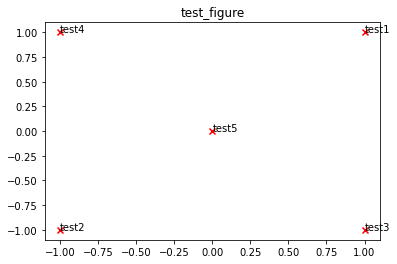

In [149]:
def plot_embeddings(X_reduced, word2Ind, words, fig_size, fig_title):
    """
    Plot in a scatterplot the embeddings of the words specified in the list "words".

    params:
        X_reduced --- numpy array of shape (num_words , 2): numpy array of 2-d word embeddings
        word2Ind --- dict: dictionary that maps words to indices
        words --- list[str]: a list of words of which the embeddings we want to visualize
        fig_size --- tuple (a,b) : the size of figure
        fig_title --- str: title of the figure
    return:
        None
    """
    plt.figure(figsize=fig_size)
    ### YOUR CODE HERE

    for i in range(len(words)):
        x = X_reduced[i][0]
        y = X_reduced[i][1]
        plt.scatter(x, y, c="red", marker="x")
        plt.text(x, y, words[i])

    plt.title(fig_title)
    ### END OF YOUR CODE


X_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {"test1": 0, "test2": 1, "test3": 2, "test4": 3, "test5": 4}
words = ["test1", "test2", "test3", "test4", "test5"]
plot_embeddings(X_test, word2Ind_plot_test, words, (6, 4), "test_figure")


--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


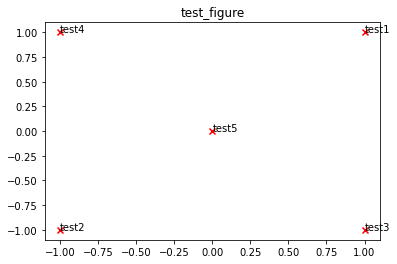

In [150]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

X_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(X_test, word2Ind_plot_test, words, (6,4), 'test_figure')

print ("-" * 80)

##### <font color=red>**Test Plot Solution**</font>
<br>
<img src="data/test_plot.png" width=40% style="float: left;"> </img>

Initialzie + distinct_words 0.0032339096069335938
word2index 0.0006222724914550781
CoM 0.27842283248901367


/var/folders/0_/3r79lvxx429gwcrb5v1q10f80000gn/T/ipykernel_4215/1345325521.py:65: RuntimeWarning: divide by zero encountered in log2
  NPMI[i, j] = np.log2(p_ij(CoM, i, j) / (p_i(i) * p_j(j)))


NPMI double for loop 95.18156814575195


/var/folders/0_/3r79lvxx429gwcrb5v1q10f80000gn/T/ipykernel_4215/1345325521.py:71: RuntimeWarning: divide by zero encountered in log2
  h_cw = np.log2(CoM / COM_SUM) * -1


h_cw calculation 0.48030900955200195
compute matrix 96.0282838344574
dim reduction CoM 0.7781171798706055
Dim reduction PPMI 1.025338888168335


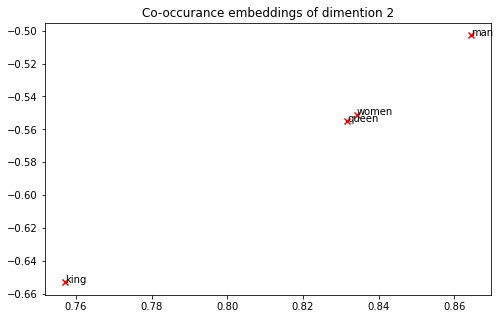

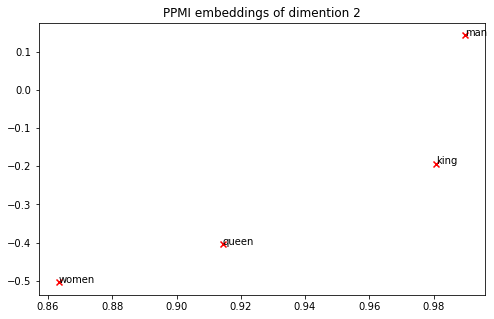

In [151]:
# -----------------------------
# Run This Cell to Produce Your Plot
# window_size is 3
# ------------------------------


# corpus = read_corpus(r'./data/ptb.train.txt', 50000)
corpus = read_corpus(r"./wikitext-2/wiki.train.tokens", 50000)
# corpus = read_corpus(r"./wikitext-2/wiki.train.tokens", 50000)

start = time.time()
CoM, PPMI, word2Ind = compute_word_matrix(corpus, window_size=3)
end = time.time()
print("compute matrix", end - start)

start = end
CoM_reduced = dimension_reduction(CoM, k=2)
end = time.time()
print("dim reduction CoM", end - start)

start = end
PPMI_reduced = dimension_reduction(PPMI, k=2)
end = time.time()
print("Dim reduction PPMI", end - start)
start = end

# Rescale (normalize) the rows to make them each of unit-length
CoM_lengths = np.linalg.norm(CoM_reduced, axis=1)
CoM_normalized = CoM_reduced / CoM_lengths[:, np.newaxis]  # broadcasting
PPMI_lengths = np.linalg.norm(PPMI_reduced, axis=1)
PPMI_normalized = PPMI_reduced / PPMI_lengths[:, np.newaxis]  # broadcasting


words = ["king", "women", "queen", "man"]
plot_embeddings(
    CoM_normalized, word2Ind, words, (8, 5), "Co-occurance embeddings of dimention 2"
)
plot_embeddings(
    PPMI_normalized, word2Ind, words, (8, 5), "PPMI embeddings of dimention 2"
)


## 2. Prediction-Based Word Embeddings
### Word2vec
Word2vec is a software package that contains two algorithms named CBOW and skip-gram ([Mikolov 2013](https://arxiv.org/pdf/1301.3781.pdf)). In the CBOW architecture, the model predicts the current word from a window of surrounding context words. In the continuous skip-gram architecture, the model uses the current word to predict the surrounding window of context words. The architectures are shown as follows:
<br>
<img src="data/Word2vec.png" width=60% style="float: left;"> </img>

### Question 2.1 [code]:
Complete the code in the function *create_word_batch*, which can be used to divide a single sequence of words into batches of words. 

For example, the word sequence ["I", "like", "NLP", "So", "does", "he"] can be divided into two batches, ["I", "like", "NLP"], ["So", "does", "he"], each with batch_size=3 words. It is more efficient to train word embedding on batches of word sequences rather than on a long single sequence. 

Then, run the sanity check cell to check your implementation.

In [152]:
def create_word_batch(words, batch_size=100):
    """
    Split the words into batches
    params:
        words --- list[str]: a list of words
        batch_size --- int: the number of words in a batch
    return:
        batch_words: list[list[str]]batches of words, list
    """
    batch_words = []

    ### YOUR CODE HERE
    batch_words = np.array_split(words, math.ceil(len(words) / batch_size))
    batch_words = [list(batch) for batch in batch_words]
    ### END OF YOUR CODE
    return batch_words


# create_word_batch(["I", "like", "NLP", "So", "does", "he", "asdf"], 3)


In [153]:
# --------------------------------------------------
# Run this sanity check to check your implementation
# --------------------------------------------------
words_test = ["I", "like", "NLP", "So", "does", "he"]
batch_size_test = 3

ans = [["I", "like", "NLP"], ["So", "does", "he"]]

batch_words_test = create_word_batch(words_test, batch_size_test)

assert ans == batch_words_test, 'your output does not match "ans"'
print("passed!")


passed!


### Question 2.2 [code]:
Use "Word2Vec" function to build a word2vec model. For the use of "Word2Vec" function, please ,refer to https://radimrehurek.com/gensim/models/word2vec.html. Please use the parameters we have set for you.

It may take a few minutes to train the model.

In [154]:
# whole_corpus = corpus = read_corpus(r'./data/ptb.train.txt', 'all')
whole_corpus = corpus = read_corpus(r"./wikitext-2/wiki.train.tokens", "all")
batch_words = create_word_batch(whole_corpus)

vector_size = 100
min_count = 2
window = 3
sg = 1  # skip-gram algorithm

### YOUR CODE HERE
model = Word2Vec(
    sentences=batch_words,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=10,
)
# model.save("word2vec.model")
### END OF YOUR CODE

print("Done!")


Done!


### Question 2.3 [code]:
Implement "get_word2Ind" function below first. Then, run the sanity check cell to check your implementation.

Use "get_word2Ind", "dimension_reduction", and "plot_embeddings" functions to visualize the word embeddings of the first 300 words in the vocabulary. 

In [155]:
def get_word2Ind(index2word):
    """
    construct a dictionary that maps words to its index

    params:
        index2word --- list[str]: list of words
    return
        word2index --- dict: keys are words, values are the corresponding indices
    """
    word2index = dict()
    ### YOUR CODE HERE
    for i in range(len(index2word)):
        word2index[index2word[i]] = i
    ### END OF YOUR CODE
    return word2index


In [156]:
# --------------------------------------------------
# Run this sanity check to check your implementation
# --------------------------------------------------
i2w_test = ["I", "love", "it"]
ans_test = get_word2Ind(i2w_test)

ans = {"I": 0, "love": 1, "it": 2}
assert ans == ans_test, "your output did not match the correct answer."
print("passed!")


passed!


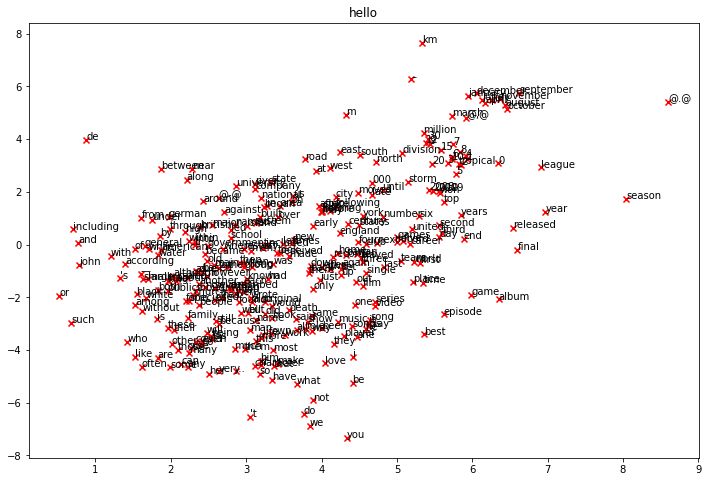

In [157]:
index2word = model.wv.index_to_key
words_to_visualize = index2word[:300]

### YOUR CODE HERE
dim = np.empty((0, 100))
for i in range(300):
    dim = np.row_stack((dim, model.wv[words_to_visualize[i]]))

dim_reduced = dimension_reduction(dim, k=2)
plot_embeddings(dim_reduced, words_to_visualize, words_to_visualize, (12, 8), "hello")
### END OF YOUR CODE


### Question 2.4 [code]:
1. Find the most similar words for the given words "man","woman","king". You need to use "model.wv.most_similar" function.
2. Find out which word will it be for x in the pairs author : singer :: book : x? You need to use "model.wv.most_similar" function.

In [158]:
words = ["man", "woman", "king"]
### 1
### YOUR CODE HERE
model.wv.most_similar(
    positive=["man", "woman", "king"],
)
# ANSWER is friend

### END OF YOUR CODE


[('child', 0.8951638340950012),
 ('girl', 0.8851626515388489),
 ('friend', 0.8806236982345581),
 ('lady', 0.8501633405685425),
 ('voice', 0.8460336327552795),
 ('bond', 0.8372470140457153),
 ('mother', 0.8336653113365173),
 ('yue', 0.8307801485061646),
 ('jealous', 0.8244190812110901),
 ('son', 0.8230921030044556)]

In [159]:
# ### 2
# ### YOUR CODE HERE
model.wv.most_similar(
    positive=["author", "singer"],
)
# ANSWER is writer
# ### END OF YOUR CODE


[('writer', 0.908018171787262),
 ('creator', 0.9066494703292847),
 ('poet', 0.9055471420288086),
 ('composer', 0.9043450951576233),
 ('publisher', 0.8911311030387878),
 ('actor', 0.891123354434967),
 ('critic', 0.8896278142929077),
 ('murphy', 0.8884673714637756),
 ('tom', 0.8843621015548706),
 ('jazz', 0.8835170269012451)]

### Question 2.5 [code+written]:

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Use the `most_similar` function to find two cases where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [160]:
### YOUR CODE HERE
comparison = "asian"

print(
    model.wv.similarity(comparison, "bad"), model.wv.similarity(comparison, "good")
)
#0.43832785 0.18442458 asian is closer to bad 


comparison = "robbery"
print(
    model.wv.similarity(comparison, "male"), model.wv.similarity(comparison, "female")
)
#0.63172656 0.61233956 male is associated more to robbery

### END OF YOUR CODE


0.47682014 0.19899859
0.6869453 0.6197745


**_Write your explanation:_** This biasness is due to the text that we input to the model. The more bias the texts are towards a certain group of people, the more bias the model will be

